In [1]:
import numpy as np
from random import gauss
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy.stats import norm
import statistics
import time 

Documentation pour la fonction *norm.pdf* : https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

Le modèle est le suivant :
$$x_t = \alpha + \beta x_{t-1} + \omega_t \text{ , avec } \omega_t \sim \mathcal{N}(0,W)$$
$$y_t = \mu + exp(\frac{x_t}{2})v_t \text{ , avec } v_t \sim \mathcal{N}(0,1)$$
Où, 
* $y_t$ est le rentabilité journalière
* $x_t$ est la log-variance au temps $t$ (i.e. la volatilité)

On crée les couples $(X_{0:t},Y_{0:t})$ :

In [2]:
# Constantes

alpha= 0
W_cst = 1
beta = 0.9702

mu = 0
phi = 0.5992


In [3]:
def couple(t,X_0):
    res = np.zeros((t,2))

    res[0,0] = X_0
    res[0,1] = mu + np.exp(res[0,0]/2)*phi*gauss(0,1)

    for k in range(1,t):
        #observations[k,0] = 0.5*observations[k-1,0]+25*observations[k-1,0]/(1+observations[k-1,0]**2)+8*np.cos(1.2*k) + gauss(0,Q) # X_t
        #observations[k,1] = observations[k,0]**2/20 + gauss(0,R) # Y_t
        
        res[k,0] = alpha + beta*res[k-1,0]+ np.random.normal(0,W_cst)
        res[k,1] = mu + np.exp(res[k,0]/2)*phi*(np.random.normal(0,1))

    return res[:,0],res[:,1]


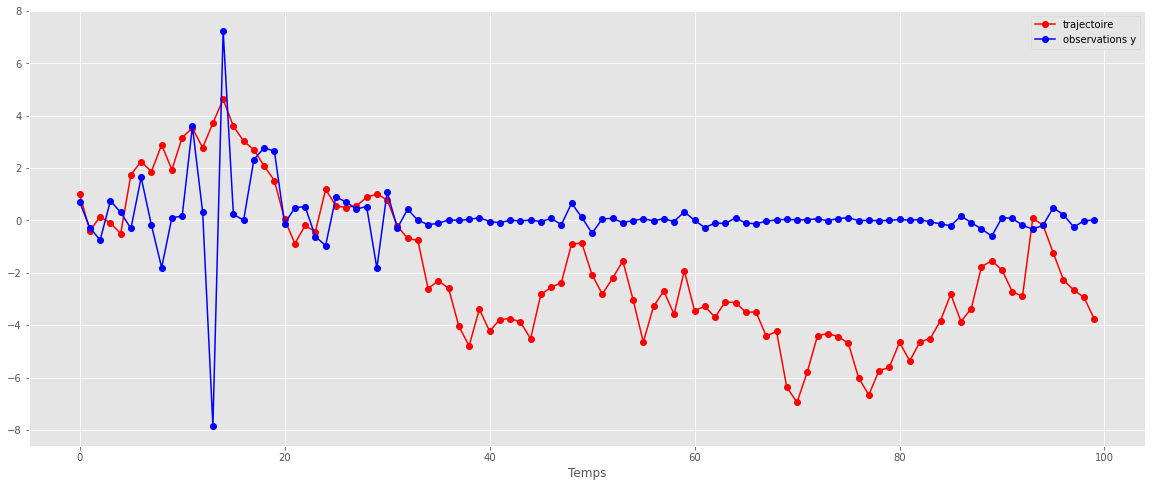

In [4]:
T = 100
X_0 = 1

x,y=couple(T,X_0)
L_t=[t for t in range(T)]

plt.figure(figsize=(20,8))
plt.plot(L_t,x,'-o',color='red',label='trajectoire')
plt.plot(L_t,y,'-o',color='b',label='observations y')
plt.xlabel('Temps')
plt.legend()
plt.show()

On suppose maintenant qu'on ait que les observations 

In [5]:
def filtrage_particulaire(T,Y,N):
    # N est le nombre de particules

    X_0 = np.random.randn(N)
    X = np.zeros((T,N))

    # w_0 = norm.pdf(Y[0],X_0**2/20,Q) # à modifier
    w_0 = norm.pdf(Y[0],0,phi**2*np.exp(X_0/2))# le problème vient d'ici
    w_0 = w_0/(w_0.sum())
    W = np.zeros((T,N))
    W[0,:] += w_0
    
    for t in range(1,T):
        A = np.random.choice(range(N),N,p=W[t-1,:])
           
        # X[t,:] = np.random.normal(0.5*X[t-1][A]+25*X[t-1][A]/(1+X[t-1][A]**2)+8*np.cos(1.2*t),Q,N) # à modifier
        X[t,:] = np.random.normal(alpha+beta*X[t-1][A],W_cst,N) 
        
        # W[t,:] = norm.pdf(Y[t],X[t,:]**2/20,R) # à modifier
        W[t,:] = norm.pdf(Y[t],0,phi**2*np.exp(X[t,:]/2)) # le problème vient d'ici
        
        #print('----------')
        #print('Les poids avant \n', W[t,:], '\n')
        #print('Les valeurs prises par X \n', X[t,:], '\n')
        #print('Les observations Y \n', Y[t], '\n')
        
        W[t,:] = W[t,:]/(W[t,:].sum()) 
        
        #print('Les poids après \n', W[t,:])
        

    return W,X

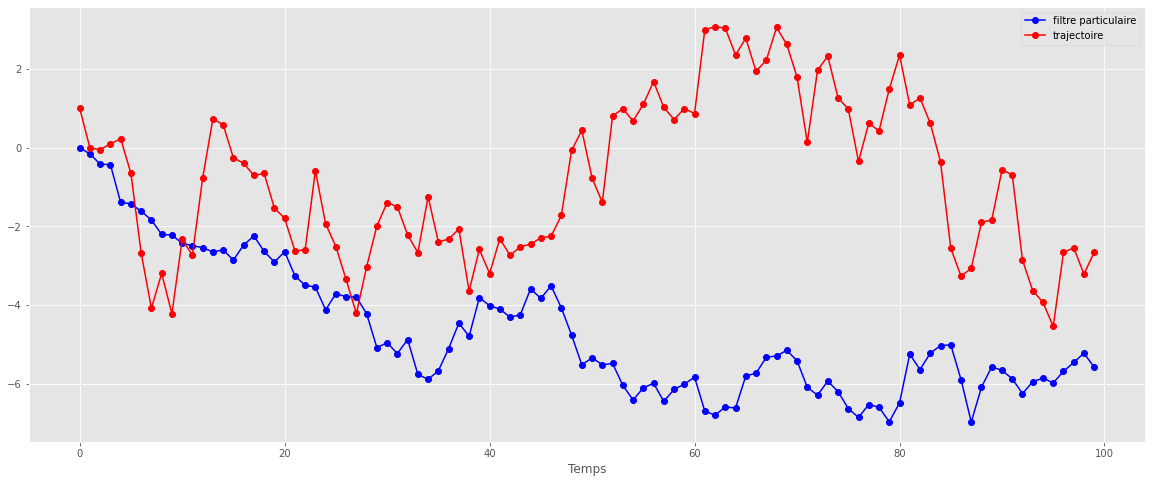

In [6]:
T = 100
N = 100
x,y=couple(T,1)
L_t=[t for t in range(T)]

W,X = filtrage_particulaire(T,y,N)
matrice = W*X 
L = []
for t in range(T):
    L.append(matrice[t,:].sum())

plt.figure(figsize=(20,8))
plt.plot(L_t,L,'-o',color='blue',label='filtre particulaire')
plt.plot(L_t,x,'-o',color='red',label='trajectoire')
#plt.plot(L_t,y,'-o',color='g',label='observations')
plt.xlabel('Temps')
plt.legend()
plt.show()

### Erreur Quadratique Moyenne

In [7]:
def EQM(L,x):
    res = []
    T = len(L)
    for t in range(T):
        res.append((x[t]-L[t])**2)
    return res

def EQM_NN(LL,x):
    # calcul de l'EQM pour NN particules
    res = []
    for L in LL:
        res.append(statistics.mean(EQM(L,x)))
    return res

In [8]:
T = 100
NN = 100
x,y=couple(T,1)
L_t=[t for t in range(T)]
LL = []
for N in range(100,NN+500):
    W,X = filtrage_particulaire(T,y,N)

    matrice = W*X 
    L = []
    for t in range(T):
        L.append(matrice[t,:].sum())
    LL.append(L)

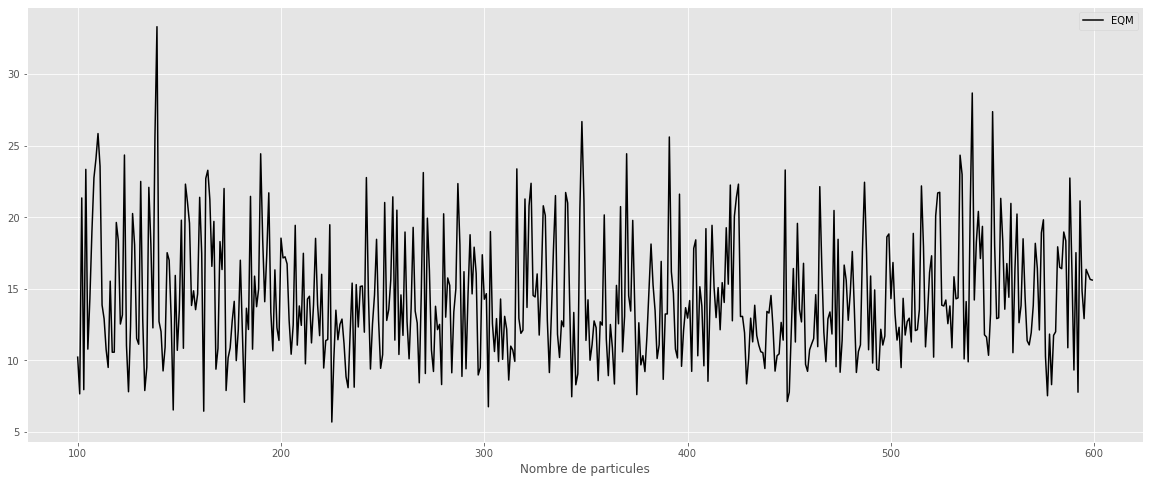

In [10]:
plt.figure(figsize=(20,8))

# EQM 
plt.plot(range(100,NN+500),EQM_NN(LL,x),'-',color='black',label='EQM')

# EQM sommé
#plt.plot(range(1,NN+1),[sum(EQM_NN(LL,x)[:i]) for i in range(1,NN+1)],'-',color='blue',label='EQM')

plt.xlabel('Nombre de particules')
plt.legend()
plt.show()

In [38]:
T = 100
NN = 10
NNN = 100
matrix = np.zeros((NNN,NN))

L_max = []
L_min = []

for j in range(NNN):
    print(j)
    x,y=couple(T,1)
    L_t=[t for t in range(T)]
    LL = []
    for N in range(1,NN+1):
        W,X = filtrage_particulaire(T,y,N)
        matrice = W*X 
        
        L = []
        for t in range(T):
            L.append(matrice[t,:].sum())
        LL.append(L)

    matrix[j,:] += EQM_NN(LL,x)

L_moyenne = [statistics.mean(matrix[:,i]) for i in range(NN)]
L_max = [max(matrix[:,i]) for i in range(NN)]
L_min = [min(matrix[:,i]) for i in range(NN)]

0
1
2


C:\Users\utilisateur\AppData\Local\Temp\ipykernel_9244\1137186738.py:21: RuntimeWarning: invalid value encountered in divide
  W[t,:] = W[t,:]/(W[t,:].sum())


ValueError: probabilities contain NaN

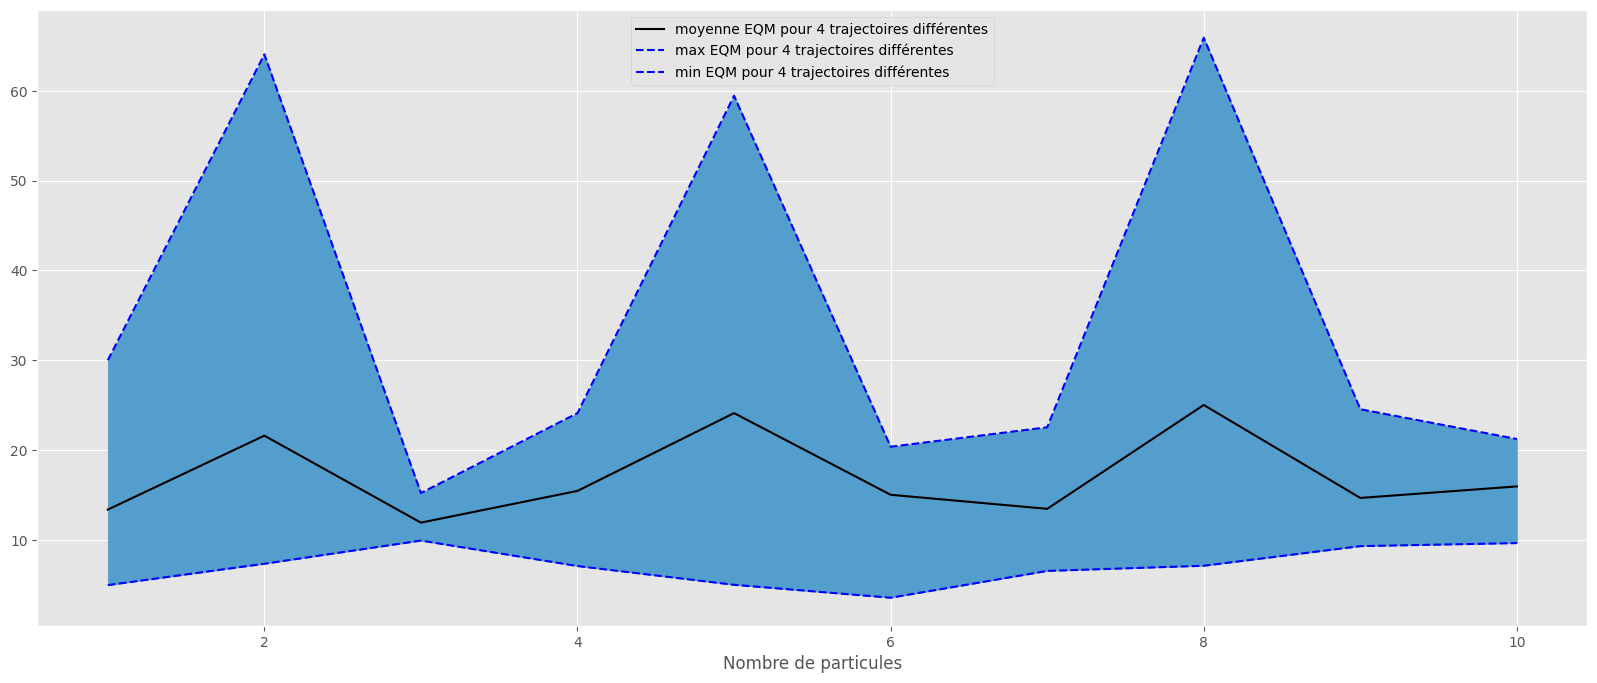

In [37]:
plt.figure(figsize=(20,8))
plt.plot(range(1,NN+1),L_moyenne,'-',color='black',label='moyenne EQM pour ' + str(NNN) +' trajectoires différentes')
plt.plot(range(1,NN+1), L_max,'--',color='blue',label='max EQM pour ' + str(NNN) +' trajectoires différentes')
plt.plot(range(1,NN+1), L_min,'--',color='blue',label='min EQM pour ' + str(NNN) +' trajectoires différentes')
plt.fill_between(range(1,NN+1), L_max, L_min,color='#539ecd')
plt.xlabel('Nombre de particules')
plt.legend()
plt.show()

### Temps d'exécution

In [ ]:
T = 100
NN = 250
precision = 100
L_res = []
L_max = []
L_min = []

for N in range(1,NN+1):
    print(N)
    L_temps = []

    for _ in range(precision):

        x,y = couple(T,1)

        start = time.time()
        W,X = filtrage_particulaire(T,y,N)

        matrice = W*X 
        L = []
        for t in range(T):
            L.append(matrice[t,:].sum())
        
        L_temps.append(time.time()-start)
    
    L_res.append(statistics.mean(L_temps))
    L_max.append(max(L_temps))
    L_min.append(min(L_temps))

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(range(1,NN+1),L_res,'-',color='orange',label='moyenne des durées d\'exécution sur ' + str(precision) + ' applications du filtre particulaire')
plt.plot(range(1,NN+1), L_max,'--',color='blue',label='max des durées d\'exécution sur ' + str(precision) + ' applications du filtre particulaire')
plt.plot(range(1,NN+1), L_min,'--',color='blue',label='min des durées d\'exécution sur ' + str(precision) + ' applications du filtre particulaire')
plt.fill_between(range(1,NN+1), L_max, L_min,color='#539ecd')
plt.xlabel('Nombre de particules')
plt.legend()
plt.show()